# Sonar Multi-class Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Sonar Signal Result**_

---

---

## Background

This notebook is to demonstrate how to train a XGBoost ML model with pre-labelled sonar data. The data contains 60 numerical fields and 1 label field for each row/record.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
import sagemaker
sess = sagemaker.Session()
bucket = 'chen115y-test'
prefix = 'sonar-data'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [2]:
print(sagemaker.__version__)

2.24.1


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler # StandardScaler
import pickle as pkl
import tarfile
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

---
## Data/Feature Engineering

In this notebook, the training data set is a type of sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock.

The [dataset](https://archive.ics.uci.edu/ml/datasets/Connectionist%20Bench%20(Sonar,%20Mines%20vs.%20Rocks)) we use is publicly available at UCI Machine Learning Repository website. It was contributed to the benchmark collection by Terry Sejnowski, now at the Salk Institute and the University of California at San Deigo. The data set was developed in collaboration with R. Paul Gorman of Allied-Signal Aerospace Technology Center.

The dataset csv file doesn't have a header. It contains 208 records and 60 columns to present 208 instances of sonar scan information. The last column is the label to show if sonar signals bounced off a metal cylinder or cylindrical rock.

### Load Data

In [4]:
# Download the dataset from S3 bucket
s3 = boto3.client('s3')
s3.download_file('chen115y-test', 'sonar-data/sonar.all-data.csv', 'sonar-data.csv')

In [5]:
sonar = pd.read_csv('sonar-data.csv', header=None)
pd.set_option('display.max_columns', 500)
sonar.head(208)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,0.3108,0.2933,0.2275,0.0994,0.1801,0.2200,0.2732,0.2862,0.2034,0.1740,0.4130,0.6879,0.8120,0.8453,0.8919,0.9300,0.9987,1.0000,0.8104,0.6199,0.6041,0.5547,0.4160,0.1472,0.0849,0.0608,0.0969,0.1411,0.1676,0.1200,0.1201,0.1036,0.1977,0.1339,0.0902,0.1085,0.1521,0.1363,0.0858,0.0290,0.0203,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,0.3085,0.3425,0.2990,0.1402,0.1235,0.1534,0.1901,0.2429,0.2120,0.2395,0.3272,0.5949,0.8302,0.9045,0.9888,0.9912,0.9448,1.0000,0.9092,0.7412,0.7691,0.7117,0.5304,0.2131,0.0928,0.1297,0.1159,0.1226,0.1768,0.0345,0.1562,0.0824,0.1149,0.1694,0.0954,0.0080,0.0790,0.1255,0.0647,0.0179,0.0051,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,0.2716,0.2374,0.1878,0.0983,0.0683,0.1503,0.1723,0.2339,0.1962,0.1395,0.3164,0.5888,0.7631,0.8473,0.9424,0.9986,0.9699,1.0000,0.8630,0.6979,0.7717,0.7305,0.5197,0.1786,0.1098,0.1446,0.1066,0.1440,0.1929,0.0325,0.1490,0.0328,0.0537,0.1309,0.0910,0.0757,0.1059,0.1005,0.0535,0.0235,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,0.2898,0.2812,0.1578,0.0273,0.0673,0.1444,0.2070,0.2645,0.2828,0.4293,0.5685,0.6990,0.7246,0.7622,0.9242,1

### Data Explore

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

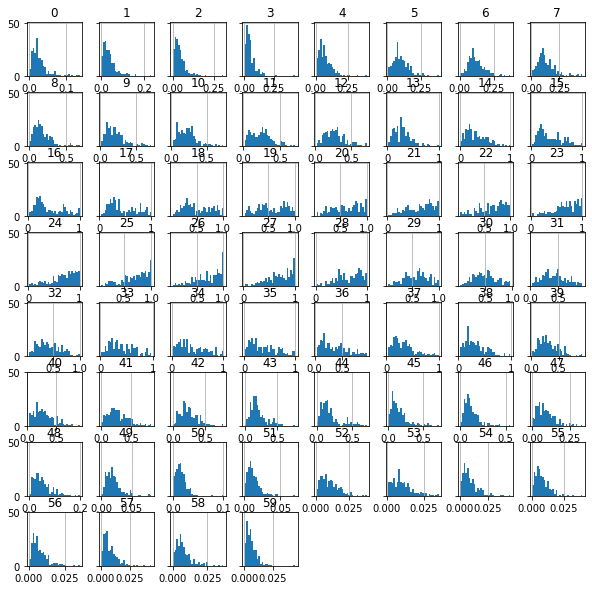

In [6]:
# Frequency tables for each categorical feature
# for column in churn.select_dtypes(include=['object']).columns:
#     display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(sonar.describe())
%matplotlib inline
hist = sonar.hist(bins=30, sharey=True, figsize=(10, 10))

Next let's look at the relationship between each of the features and our target variable.

In [7]:
print(sonar.columns)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
           dtype='int64')


In [9]:
display(sonar.corr())
# pd.plotting.scatter_matrix(sonar, figsize=(12, 12))
# plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.735896,0.571537,0.491438,0.344797,0.238921,0.260815,0.355523,0.353420,0.318276,0.344058,0.210861,0.210722,0.256278,0.304878,0.239079,0.137845,0.041817,0.055227,0.156760,0.117663,-0.056973,-0.163426,-0.218093,-0.295683,-0.342865,-0.341703,-0.224340,-0.199099,-0.077430,-0.048370,-0.030444,-0.031939,0.031319,0.098118,0.080722,0.119565,0.209873,0.208371,0.099993,0.127313,0.213592,0.206057,0.157949,0.279968,0.319354,0.230343,0.203234,0.247560,0.269287,0.254450,0.355299,0.311729,0.322299,0.312067,0.220642,0.313725,0.368132,0.357116,0.347078
1,0.735896,1.000000,0.779916,0.606684,0.419669,0.332329,0.279040,0.334615,0.316733,0.270782,0.297065,0.194102,0.249596,0.273170,0.307599,0.261844,0.152170,0.042870,0.040911,0.102428,0.075255,-0.074157,-0.179365,-0.196469,-0.295302,-0.365749,-0.337046,-0.234386,-0.228490,-0.115301,-0.055862,-0.049683,-0.108272,-0.004247,0.115824,0.132611,0.169186,0.217494,0.186828,0.098350,0.188226,0.261345,0.186368,0.133018,0.285716,0.304247,0.255797,0.265279,0.313995,0.245868,0.320538,0.434548,0.346076,0.383960,0.380165,0.262263,0.280341,0.353042,0.352200,0.358761
2,0.571537,0.779916,1.000000,0.781786,0.546141,0.346275,0.190434,0.237884,0.252691,0.219637,0.274610,0.214807,0.258767,0.291724,0.285663,0.237017,0.201093,0.120587,0.099303,0.103117,0.063990,-0.026815,-0.073400,-0.085380,-0.214256,-0.291974,-0.263111,-0.256674,-0.290728,-0.197493,-0.106198,-0.109895,-0.170671,-0.099409,0.017053,0.053070,0.107530,0.130276,0.110499,0.074137,0.189047,0.233442,0.113920,0.071946,0.180734,0.173649,0.179528,0.234896,0.223074,0.081096,0.238110,0.394076,0.332914,0.367186,0.289731,0.287661,0.380819,0.334108,0.425047,0.373948
3,0.491438,0.606684,0.781786,1.000000,0.726943,0.352805,0.246440,0.246742,0.247078,0.237769,0.271881,0.175381,0.215754,0.286708,0.278529,0.248245,0.223203,0.194992,0.189405,0.188317,0.142271,0.036010,-0.029749,-0.102975,-0.206673,-0.291357,-0.294749,-0.256074,-0.300476,-0.236602,-0.190086,-0.169987,-0.164651,-0.083965,0.015200,0.039282,0.063486,0.089887,0.089346,0.045141,0.145241,0.144693,0.050629,-0.008407,0.087824,0.080012,0.046109,0.121065,0.133294,0.077925,0.174676,0.374651,0.364772,0.334211,0.284955,0.280938,0.340254,0.344865,0.420266,0.400626
4,0.344797,0.419669,0.546141,0.726943,1.000000,0.597053,0.335422,0.204006,0.177906,0.183219,0.231684,0.211657,0.299086,0.359062,0.318059,0.328725,0.326477,0.299266,0.340543,0.285737,0.205088,0.152897,0.073934,-0.000624,-0.067296,-0.125675,-0.169618,-0.214692,-0.283863,-0.273350,-0.214336,-0.173485,-0.200586,-0.140559,-0.086529,-0.073481,-0.064617,-0.008620,0.063408,0.061616,0.098832,0.125181,0.063706,0.031575,0.089202,0.081964,0.041419,0.084435,0.088128,0.066751,0.115936,0.266617,0.314985,0.205306,0.196472,0.199323,0.219395,0.238793,0.290982,0.253710
5,0.238921,0.332329,0.346275,0.352805,0.597053,1.000000,0.702889,0.471683,0.327578,0.288621,0.333570,0.344451,0.411107,0.396233,0.367908,0.353783,0.293190,0.235778,0.226305,0.206841,0.174768,0.123770,0.064081,0.027026,-0.043280,-0.100309,-0.129094,-0.118645,-0.156081,-0.151186,-0.054136,-0.051934,-0.144391,-0.070337,-0.028815,-0.023621,-0.064798,-0.048745,0.030599,0.081119,0.075797,0.048763,0.034380,0.048870,0.085468,0.029524,0.016640,0.067196,0.080729,0.017300,0.171767,0.252288,0.162404,0.164073,0.133464,0.166758,0.161333,0.203986,0.220573,0.178158
6,0.260815,0.279040,0.190434,0.246440,0.335422,0.702889,1.000000,0.675774,0.470580,0.425448,0.396588,0.274432,0.365391,0.409576,0.411692,0.363086,0.250024,0.208057,0.215495,0.196496,0.165827,0.063773,0.009359,0.011982,-0.057147,-0.126074,-0.179526,-0.116848,-0.129694,-0.068142,-0.096945,-0.115871,-0.127052,-0.077662,-0.015531,0.002979,-0.001376,0.065900,0.080942,0.112673,0.041071,-0.028720,-0.025727,0.061404,0.110813,0.076537,0.098925,0.155221,0.194720,0.166112,0.184152,0.144051,0.046403,0.16

### Data Encoding and Normalization

Now that we've cleaned dataset, let's determine which algorithm to use. Let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

First, let's convert any categrical values into numerical values.

In [10]:
le = LabelEncoder()
sonar['label'] = le.fit_transform(sonar[60])
model_data = pd.concat([sonar['label'], sonar.drop([60,'label'], axis=1)], axis=1)
model_data.head(208)

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,1,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,1,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,0.3108,0.2933,0.2275,0.0994,0.1801,0.2200,0.2732,0.2862,0.2034,0.1740,0.4130,0.6879,0.8120,0.8453,0.8919,0.9300,0.9987,1.0000,0.8104,0.6199,0.6041,0.5547,0.4160,0.1472,0.0849,0.0608,0.0969,0.1411,0.1676,0.1200,0.1201,0.1036,0.1977,0.1339,0.0902,0.1085,0.1521,0.1363,0.0858,0.0290,0.0203,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157
204,0,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,0.3085,0.3425,0.2990,0.1402,0.1235,0.1534,0.1901,0.2429,0.2120,0.2395,0.3272,0.5949,0.8302,0.9045,0.9888,0.9912,0.9448,1.0000,0.9092,0.7412,0.7691,0.7117,0.5304,0.2131,0.0928,0.1297,0.1159,0.1226,0.1768,0.0345,0.1562,0.0824,0.1149,0.1694,0.0954,0.0080,0.0790,0.1255,0.0647,0.0179,0.0051,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067
205,0,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,0.2716,0.2374,0.1878,0.0983,0.0683,0.1503,0.1723,0.2339,0.1962,0.1395,0.3164,0.5888,0.7631,0.8473,0.9424,0.9986,0.9699,1.0000,0.8630,0.6979,0.7717,0.7305,0.5197,0.1786,0.1098,0.1446,0.1066,0.1440,0.1929,0.0325,0.1490,0.0328,0.0537,0.1309,0.0910,0.0757,0.1059,0.1005,0.0535,0.0235,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031
206,0,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,0.2898,0.2812,0.1578,0.0273,0.0673,0.1444,0.2070,0.2645,0.2828,0.4293,0.5685,0.6990,0.7246,0.7622,0.9

For some ML algorithms (e.g. neural network, KNN, K-Means, SVM, etc.), the data feature normalization or scaling is required so that the algorithms are able to effectively and efficiently calculate the numbers. However, __xgboost doesn't require it due to its rule or tree based calculations__.

The following codes show a simple way to do feature normalization or scaling. It will be needed if a gradient descant or distance based algorithm is applied.

In [11]:
# scaler = MinMaxScaler() # StandardScaler()
# model_data = pd.DataFrame(scaler.fit_transform(model_data))
# model_data.head()

### Data Split

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

In [12]:
# Split data into train, test and validation datasets
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=42), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
print("# of training data:", len(train_data))
print("# of validation data:", len(validation_data))
print("# of test data:", len(test_data))

# of training data: 145
# of validation data: 42
# of test data: 21


In [13]:
# Save the data sets without header and index to the local folder
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

Now we'll upload these files to S3.

In [14]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

print("Training data is at:", 's3://'+bucket+'/'+prefix+'/'+'train/train.csv')
print("Validation data is at:", 's3://'+bucket+'/'+prefix+'/'+'validation/validation.csv')

Training data is at: s3://chen115y-test/sonar-data/train/train.csv
Validation data is at: s3://chen115y-test/sonar-data/validation/validation.csv


---
## Model Training

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

__Here, we have to use 1.0 version of xgboost framework/container because Neo service only support that version for xgboost framework for now.__

In [15]:
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')
display(container)

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

Then, because we're training with the CSV file format, we'll create `TrainingInput`s that our training function can use as a pointer to the files in S3.

In [16]:
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few [key hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst).

In [17]:
%%time

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=2,
                        subsample=0.8,
                        silent=0,
                        objective='multi:softmax',
                        early_stopping_rounds=5,
                        num_class=2,
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}, wait=True) 

2021-02-25 21:14:46 Starting - Starting the training job...
2021-02-25 21:15:10 Starting - Launching requested ML instancesProfilerReport-1614287686: InProgress
......
2021-02-25 21:16:11 Starting - Preparing the instances for training.........
2021-02-25 21:17:41 Downloading - Downloading input data
2021-02-25 21:17:41 Training - Downloading the training image...
2021-02-25 21:18:13 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:18:16] 145x60 matrix wit

## Hyperparameter Tuning

In [18]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,400,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:f1'

tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=10,
    strategy='Bayesian'
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False, wait=True)

## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

......................................................................................................................................................................................................................................................................................................................................................!


'Completed'

In [23]:
# Find the best training job name
print(tuner_log.best_training_job())

sagemaker-xgboost-210225-2120-051-396dd026


In [52]:
# The metric scores for the best training job
client = boto3.client('sagemaker')
client.describe_training_job(TrainingJobName=tuner_log.best_training_job())['FinalMetricDataList']

[{'MetricName': 'train:merror',
  'Value': 0.07586000114679337,
  'Timestamp': datetime.datetime(2021, 2, 25, 21, 44, 52, tzinfo=tzlocal())},
 {'MetricName': 'validation:f1',
  'Value': 0.8558400273323059,
  'Timestamp': datetime.datetime(2021, 2, 25, 21, 44, 52, tzinfo=tzlocal())},
 {'MetricName': 'validation:merror',
  'Value': 0.14285999536514282,
  'Timestamp': datetime.datetime(2021, 2, 25, 21, 44, 52, tzinfo=tzlocal())},
 {'MetricName': 'train:f1',
  'Value': 0.9236099720001221,
  'Timestamp': datetime.datetime(2021, 2, 25, 21, 44, 52, tzinfo=tzlocal())},
 {'MetricName': 'ObjectiveMetric',
  'Value': 0.8558400273323059,
  'Timestamp': datetime.datetime(2021, 2, 25, 21, 44, 52, tzinfo=tzlocal())}]

In [53]:
# Display the best training job's hyperparameter values
client.describe_training_job(TrainingJobName=tuner_log.best_training_job())['HyperParameters']

{'_tuning_objective_metric': 'validation:f1',
 'early_stopping_rounds': '5',
 'eta': '0.17788068408488172',
 'gamma': '0.24484053731725688',
 'lambda': '10.580485894453862',
 'max_delta_step': '7',
 'max_depth': '8',
 'min_child_weight': '5.75443765853886',
 'num_class': '2',
 'num_round': '10',
 'objective': 'multi:softmax',
 'silent': '0',
 'subsample': '0.79047376727902'}

In [54]:
xgb = tuner_log.best_estimator()


2021-02-25 21:45:01 Starting - Preparing the instances for training
2021-02-25 21:45:01 Downloading - Downloading input data
2021-02-25 21:45:01 Training - Training image download completed. Training in progress.
2021-02-25 21:45:01 Uploading - Uploading generated training model
2021-02-25 21:45:01 Completed - Training job completed


You can deploy directly the tuner into a sagemaker endpoint if you like by using the following codes

In [55]:
# Deploy the tuner best model
tuner_log.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


2021-02-25 21:45:01 Starting - Preparing the instances for training
2021-02-25 21:45:01 Downloading - Downloading input data
2021-02-25 21:45:01 Training - Training image download completed. Training in progress.
2021-02-25 21:45:01 Uploading - Uploading generated training model
2021-02-25 21:45:01 Completed - Training job completed
---------------!

However, we want to deploy the model into some edge devices, such as Jetson Nano or Jetson Xivar. So, we need to compile the model via SageMaker Neo service so that the compiled model can fit into the devices.

---
## Compile via SageMaker Neo
[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) optimizes models to run up to twice as fast, with no loss in accuracy. When calling `compile_model()` function, we specify the target instance family (m4) as well as the S3 bucket to which the compiled model would be stored.

In [57]:
# compiled_model = xgb
# output_path = '/'.join(xgb.output_path.split('/')[:-1])
# compiled_model = xgb.compile_model(target_instance_family='jetson_nano',
#                                    input_shape={'data': [1, 60]},
#                                    role=role,
#                                    framework='xgboost',
#                                    framework_version='latest',
#                                    output_path=output_path)
# compiled_model.name = 'sonar-xgboost-multi-classifiction-jetsonnano'

?....!

The instance type jetson_nano is not supported for deployment via SageMaker.Please deploy the model manually.


In [65]:
compiled_model = xgb
output_path = '/'.join(xgb.output_path.split('/')[:-1])
compiled_model = xgb.compile_model(target_instance_family='ml_c5',
                                   input_shape={'data': [1, 60]},
                                   role=role,
                                   framework='xgboost',
                                   framework_version='latest',
                                   output_path=output_path)
compiled_model.name = 'sonar-xgboost-multi-classifiction-mlc5'

?....!

In [66]:
print(output_path)

s3://chen115y-test/sonar-data


---
## Host

Now that we've trained and compiled the algorithm, let's create a model and deploy it to a hosted endpoint.

In [67]:
xgb_predictor = compiled_model.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.c5.xlarge',
    serializer=CSVSerializer())

-------------!

When the ```deploy()``` function is called, Sagemaker will create & register the model, create an end point configuration and create the final end point based on the given instance type. All of those steps can be tracked via Sagemaker console, like the screen shot below.

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [68]:
# Display 5 samples of test data
test_data.head()

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
196,0,0.0050,0.0017,0.0270,0.0450,0.0958,0.0830,0.0879,0.1220,0.1977,0.2282,0.2521,0.3484,0.3309,0.2614,0.1782,0.2055,0.2298,0.3545,0.6218,0.7265,0.8346,0.8268,0.8366,0.9408,0.9510,0.9801,0.9974,1.0000,0.9036,0.6409,0.3857,0.2908,0.2040,0.1653,0.1769,0.1140,0.0740,0.0941,0.0621,0.0426,0.0572,0.1068,0.1909,0.2229,0.2203,0.2265,0.1766,0.1097,0.0558,0.0142,0.0281,0.0165,0.0056,0.0010,0.0027,0.0062,0.0024,0.0063,0.0017,0.0028
1,1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
52,1,0.0087,0.0046,0.0081,0.0230,0.0586,0.0682,0.0993,0.0717,0.0576,0.0818,0.1315,0.1862,0.2789,0.2579,0.2240,0.2568,0.2933,0.2991,0.3924,0.4691,0.5665,0.6464,0.6774,0.7577,0.8856,0.9419,1.0000,0.8564,0.6790,0.5587,0.4147,0.2946,0.2025,0.0688,0.1171,0.2157,0.2216,0.2776,0.2309,0.1444,0.1513,0.1745,0.1756,0.1424,0.0908,0.0138,0.0469,0.0480,0.0159,0.0045,0.0015,0.0052,0.0038,0.0079,0.0114,0.0050,0.0030,0.0064,0.0058,0.0030
149,0,0.0207,0.0535,0.0334,0.0818,0.0740,0.0324,0.0918,0.1070,0.1553,0.1234,0.1796,0.1787,0.1247,0.2577,0.3370,0.3990,0.1647,0.2266,0.3219,0.5356,0.8159,1.0000,0.8701,0.6889,0.6299,0.5738,0.5707,0.5976,0.4301,0.2058,0.1000,0.2247,0.2308,0.3977,0.3317,0.1726,0.1429,0.2168,0.1967,0.2140,0.3674,0.2023,0.0778,0.0925,0.2388,0.3400,0.2594,0.1102,0.0911,0.0462,0.0171,0.0033,0.0050,0.0190,0.0103,0.0121,0.0042,0.0090,0.0070,0.0099
130,0,0.0443,0.0446,0.0235,0.1008,0.2252,0.2611,0.2061,0.1668,0.1801,0.3083,0.3794,0.5364,0.6173,0.7842,0.8392,0.9016,1.0000,0.8911,0.8753,0.7886,0.7156,0.7581,0.6372,0.3210,0.2076,0.2279,0.3309,0.2847,0.1949,0.1671,0.1025,0.1362,0.2212,0.1124,0.1677,0.1039,0.2562,0.2624,0.2236,0.1180,0.1103,0.2831,0.2385,0.0255,0.1967,0.1483,0.0434,0.0627,0.0513,0.0473,0.0248,0.0274,0.0205,0.0141,0.0185,0.0055,0.0045,0.0115,0.0152,0.0100


In [69]:
# For prediction, we need to convert test_data from data frame into a numpy array without the label column
# Display the feature part (no label) of test data
test_data.to_numpy()[:,1:]

array([[0.005 , 0.0017, 0.027 , ..., 0.0063, 0.0017, 0.0028],
       [0.0453, 0.0523, 0.0843, ..., 0.0049, 0.0052, 0.0044],
       [0.0087, 0.0046, 0.0081, ..., 0.0064, 0.0058, 0.003 ],
       ...,
       [0.026 , 0.0192, 0.0254, ..., 0.0008, 0.0044, 0.0077],
       [0.0394, 0.042 , 0.0446, ..., 0.0068, 0.0053, 0.0087],
       [0.0587, 0.121 , 0.1268, ..., 0.0101, 0.0228, 0.0124]])

In [75]:
# Display the label column (actual value on customer churn) only
y = test_data.to_numpy()[:, 0]
print(test_data.to_numpy()[:, 0])
len(test_data.to_numpy()[:, 0])

[0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]


21

In [71]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])

By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1

In [72]:
# Display predictions. 
print(predictions)
len(predictions)

[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]


21

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [76]:
# Evaluate predictions
predictions = [round(value) for value in predictions]
accuracy = accuracy_score(y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.19%


In [77]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0,1
actual,,
0,11,2
1,3,5


In [78]:
def plot_conf_mat(cm, classes, title, cmap = plt.cm.Blues):                                 
                                              
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[11  2]
 [ 3  5]]


<Figure size 432x288 with 0 Axes>

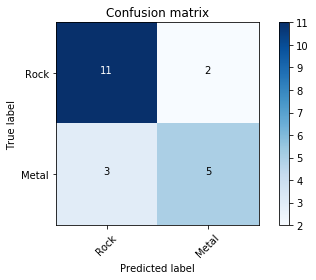

In [80]:
# Show confusion matrix
c_mat = confusion_matrix(y, predictions)
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(c_mat, classes=['Rock','Metal'], title='Confusion matrix')
plt.show()

## Inference

In [82]:
%%time

import os
import boto3
import re
import sagemaker
import time

runtime_client = boto3.client('runtime.sagemaker')
region = boto3.Session().region_name
endpoint_name = "xgboost-2021-02-24-04-53-28-334"

CPU times: user 17.4 ms, sys: 55 µs, total: 17.5 ms
Wall time: 16.6 ms


In [87]:
# The metric scores for the job
client = boto3.client('sagemaker')
client.describe_training_job(TrainingJobName='xgboost-2021-02-24-04-02-53-920')['FinalMetricDataList']

[{'MetricName': 'train:merror',
  'Value': 0.04827599972486496,
  'Timestamp': datetime.datetime(2021, 2, 24, 4, 6, 11, tzinfo=tzlocal())},
 {'MetricName': 'validation:merror',
  'Value': 0.11904799938201904,
  'Timestamp': datetime.datetime(2021, 2, 24, 4, 6, 11, tzinfo=tzlocal())}]

### A Single Inference

In [83]:
# Inference data (features without label)
# import pandas as pd
# import numpy as np
# test_data = pd.read_csv('test.csv',header=None)

# infer_data = list(test_data.to_numpy()[0,1:])
# print(infer_data)

[0.005, 0.0017, 0.027, 0.045, 0.0958, 0.083, 0.0879, 0.122, 0.1977, 0.2282, 0.2521, 0.3484, 0.3309, 0.2614, 0.1782, 0.2055, 0.2298, 0.3545, 0.6218, 0.7265, 0.8346, 0.8268, 0.8366, 0.9408, 0.951, 0.9801, 0.9974, 1.0, 0.9036, 0.6409, 0.3857, 0.2908, 0.204, 0.1653, 0.1769, 0.114, 0.074, 0.0941, 0.0621, 0.0426, 0.0572, 0.1068, 0.1909, 0.2229, 0.2203, 0.2265, 0.1766, 0.1097, 0.0558, 0.0142, 0.0281, 0.0165, 0.0056, 0.001, 0.0027, 0.0062, 0.0024, 0.0063, 0.0017, 0.0028]


In [84]:
%%time
# import json
# from itertools import islice
# import math
# import struct

# Load the test data, only need the first row
file_name = "test.csv"
with open(file_name, "r") as f:
    payloads = f.read().splitlines()
print(payloads[0])
# Remove the label column
infer_data = payloads[0][2:]

0,0.005,0.0017,0.027,0.045,0.0958,0.083,0.0879,0.122,0.1977,0.2282,0.2521,0.3484,0.3309,0.2614,0.1782,0.2055,0.2298,0.3545,0.6218,0.7265,0.8346,0.8268,0.8366,0.9408,0.951,0.9801,0.9974,1.0,0.9036,0.6409,0.3857,0.2908,0.204,0.1653,0.1769,0.114,0.074,0.0941,0.0621,0.0426,0.0572,0.1068,0.1909,0.2229,0.2203,0.2265,0.1766,0.1097,0.0558,0.0142,0.0281,0.0165,0.0056,0.001,0.0027,0.0062,0.0024,0.0063,0.0017,0.0028
CPU times: user 760 µs, sys: 30 µs, total: 790 µs
Wall time: 429 µs


In [85]:
%%time
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=infer_data)
print(response)

{'ResponseMetadata': {'RequestId': 'a504bf3f-c823-4617-baa2-b9a5e52dd9be', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a504bf3f-c823-4617-baa2-b9a5e52dd9be', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Wed, 24 Feb 2021 05:06:26 GMT', 'content-type': 'text/csv; charset=utf-8', 'content-length': '3'}, 'RetryAttempts': 0}, 'ContentType': 'text/csv; charset=utf-8', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7fb2a985e198>}
CPU times: user 15.8 ms, sys: 150 µs, total: 15.9 ms
Wall time: 71.9 ms


In [86]:
# Extract probability value from the end point response message
result = response["Body"].read()
result = result.decode("utf-8")

In [90]:
print("The prediction value is:", result)

The prediction value is: 0.0


In [91]:
# Compare the actual label value and predicted value
label = payloads[0][0].strip(" ").split()[0]
print(f"Label: {label}\nPrediction: {result}")

Label: 0
Prediction: 0.0


### Batch Inference/Transform Job

Prepare the inference data by reusing test data. We need to remove the label column before using it for inference.

In [92]:
test_data.head()

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
196,0,0.0050,0.0017,0.0270,0.0450,0.0958,0.0830,0.0879,0.1220,0.1977,0.2282,0.2521,0.3484,0.3309,0.2614,0.1782,0.2055,0.2298,0.3545,0.6218,0.7265,0.8346,0.8268,0.8366,0.9408,0.9510,0.9801,0.9974,1.0000,0.9036,0.6409,0.3857,0.2908,0.2040,0.1653,0.1769,0.1140,0.0740,0.0941,0.0621,0.0426,0.0572,0.1068,0.1909,0.2229,0.2203,0.2265,0.1766,0.1097,0.0558,0.0142,0.0281,0.0165,0.0056,0.0010,0.0027,0.0062,0.0024,0.0063,0.0017,0.0028
1,1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
52,1,0.0087,0.0046,0.0081,0.0230,0.0586,0.0682,0.0993,0.0717,0.0576,0.0818,0.1315,0.1862,0.2789,0.2579,0.2240,0.2568,0.2933,0.2991,0.3924,0.4691,0.5665,0.6464,0.6774,0.7577,0.8856,0.9419,1.0000,0.8564,0.6790,0.5587,0.4147,0.2946,0.2025,0.0688,0.1171,0.2157,0.2216,0.2776,0.2309,0.1444,0.1513,0.1745,0.1756,0.1424,0.0908,0.0138,0.0469,0.0480,0.0159,0.0045,0.0015,0.0052,0.0038,0.0079,0.0114,0.0050,0.0030,0.0064,0.0058,0.0030
149,0,0.0207,0.0535,0.0334,0.0818,0.0740,0.0324,0.0918,0.1070,0.1553,0.1234,0.1796,0.1787,0.1247,0.2577,0.3370,0.3990,0.1647,0.2266,0.3219,0.5356,0.8159,1.0000,0.8701,0.6889,0.6299,0.5738,0.5707,0.5976,0.4301,0.2058,0.1000,0.2247,0.2308,0.3977,0.3317,0.1726,0.1429,0.2168,0.1967,0.2140,0.3674,0.2023,0.0778,0.0925,0.2388,0.3400,0.2594,0.1102,0.0911,0.0462,0.0171,0.0033,0.0050,0.0190,0.0103,0.0121,0.0042,0.0090,0.0070,0.0099
130,0,0.0443,0.0446,0.0235,0.1008,0.2252,0.2611,0.2061,0.1668,0.1801,0.3083,0.3794,0.5364,0.6173,0.7842,0.8392,0.9016,1.0000,0.8911,0.8753,0.7886,0.7156,0.7581,0.6372,0.3210,0.2076,0.2279,0.3309,0.2847,0.1949,0.1671,0.1025,0.1362,0.2212,0.1124,0.1677,0.1039,0.2562,0.2624,0.2236,0.1180,0.1103,0.2831,0.2385,0.0255,0.1967,0.1483,0.0434,0.0627,0.0513,0.0473,0.0248,0.0274,0.0205,0.0141,0.0185,0.0055,0.0045,0.0115,0.0152,0.0100


In [101]:
test_data.drop("label", axis=1).to_csv("inference.csv", header=None, index=False)

In [94]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'inference/inference.csv')).upload_file('inference.csv')
print("Inference data is at:", 's3://'+bucket+'/'+prefix+'/'+'inference/inference.csv')

Inference data is at: s3://chen115y-test/sonar-data/inference/inference.csv


In [95]:
batch_job_name = 'xgboost-sonar-classification' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
batch_input = 's3://chen115y-test/sonar-data/inference/inference.csv'
batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)
model_name = 'xgboost-2021-02-24-04-53-28-334'

Define a batch inference/transform job as below

In [96]:
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "BatchStrategy": "MultiRecord",
    "TransformOutput": {
        "S3OutputPath": batch_output
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input 
            }
        },
        "ContentType": "text/csv",
        "SplitType": "Line",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

Create a batch inference/transform job based on the definition above.

In [97]:
%%time
sm = boto3.client('sagemaker')
sm.create_transform_job(**request)

# Wait the job to finish
while(True):
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if  status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    print("Transform job is still in status: " + status)    
    time.sleep(30) 

Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job ended with status: Completed
CPU times: user 221 ms, sys: 4.36 ms, total: 226 ms
Wall time: 5min 31s


Let's take a look at the batch inferenced/predicted results.

In [81]:
s3.download_file(bucket, '{}/batch-inference/inference.csv.out'.format(prefix), 'inference.csv.out')
tmp_df = pd.read_csv("inference.csv.out", header=None)
y_pred = tmp_df.to_numpy()
y_pred

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [83]:
# Evaluate predictions
accuracy = accuracy_score(y, y_pred[0])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.95%


[[11  2]
 [ 3  5]]


<Figure size 432x288 with 0 Axes>

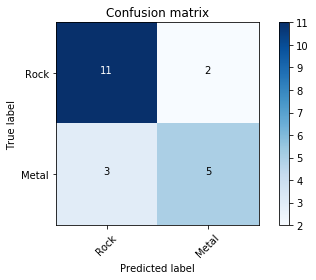

In [84]:
# Show confusion matrix
c_mat = confusion_matrix(y, predictions)
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(c_mat, classes=['Rock','Metal'], title='Confusion matrix')
plt.show()

## Compatible with Open-Source XGBoost

In [10]:
# Download the model artifact from S3
!aws s3 cp s3://chen115y-test/sonar-data/output/sagemaker-xgboost-2021-02-24-17-17-59-965/output/model.tar.gz model.tar.gz

download: s3://chen115y-test/sonar-data/output/sagemaker-xgboost-2021-02-24-17-17-59-965/output/model.tar.gz to ./model.tar.gz


In [14]:
# Install open-source XGBoost library
!pip install xgboost

     |████████████████████████████████| 157.5 MB 96 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.


In [7]:
# Load the trained xgboost model from the artifact file
import tarfile
import pickle as pkl
import xgboost as xgb
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [ ]:
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()

In [3]:
model = pkl.load(open('xgboost-model', 'rb'))

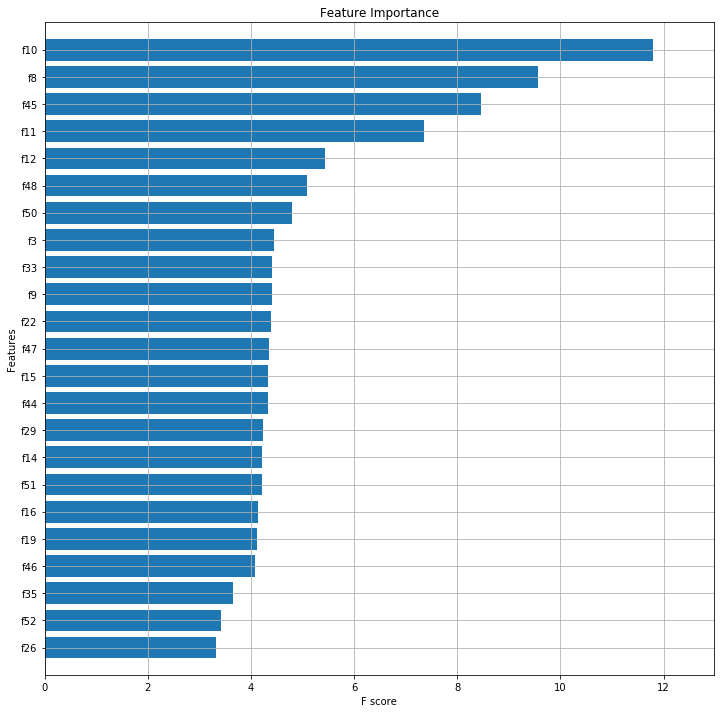

In [16]:
#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, importance_type='gain', max_num_features=100, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

In [8]:
test_data = pd.read_csv("test.csv", header=None)
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0,0.0790,0.0707,0.0352,0.1660,0.1330,0.0226,0.0771,0.2678,0.5664,...,0.0193,0.0298,0.0390,0.0294,0.0175,0.0249,0.0141,0.0073,0.0025,0.0101
1,0,0.0335,0.0258,0.0398,0.0570,0.0529,0.1091,0.1709,0.1684,0.1865,...,0.0130,0.0120,0.0039,0.0053,0.0062,0.0046,0.0045,0.0022,0.0005,0.0031
2,0,0.0072,0.0027,0.0089,0.0061,0.0420,0.0865,0.1182,0.0999,0.1976,...,0.0092,0.0078,0.0071,0.0081,0.0034,0.0064,0.0037,0.0036,0.0012,0.0037
3,0,0.0203,0.0121,0.0380,0.0128,0.0537,0.0874,0.1021,0.0852,0.1136,...,0.0209,0.0134,0.0094,0.0047,0.0045,0.0042,0.0028,0.0036,0.0013,0.0016
4,1,0.0119,0.0582,0.0623,0.0600,0.1397,0.1883,0.1422,0.1447,0.0487,...,0.0069,0.0025,0.0103,0.0074,0.0123,0.0069,0.0076,0.0073,0.0030,0.0138


In [9]:
X = xgb.DMatrix(test_data.drop(0,axis=1).values)
y = test_data[[0]].to_numpy()

In [10]:
# Do the predition/inference
y_pred = model.predict(X)
print("The predictions are:", y_pred)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

The predictions are: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Accuracy: 80.95%


# (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
xgb_predictor.delete_endpoint()